In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1130/1130 [00:21<00:00, 53.59it/s] 


In [ ]:
X_train.shape

(3200, 224, 224, 3)

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [ ]:
k.clear_session()
def inception_module(x, f1, f2, f3, f4):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.merge.concatenate([conv1, conv3, conv5, conv7])
		return x

In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [ ]:
inputs = img_input
DFUV3 =  keras.Model(inputs, x, name='DFUEffectiveNetV3')
DFUV3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV3.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 3.4262 - accuracy: 0.8556
Epoch 1: val_accuracy improved from -inf to 0.67361, saving model to AlexNet.h5
86/86 [==============================] - 17s 87ms/step - loss: 3.4262 - accuracy: 0.8556 - val_loss: 5.0056 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 2/5
85/86 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9349
Epoch 2: val_accuracy improved from 0.67361 to 0.68056, saving model to AlexNet.h5
86/86 [==============================] - 5s 64ms/step - loss: 0.1933 - accuracy: 0.9346 - val_loss: 1.0138 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9510
Epoch 3: val_accuracy improved from 0.68056 to 0.95139, saving model to AlexNet.h5
86/86 [==============================] - 5s 63ms/step - loss: 0.1814 - accuracy: 0.9510 - val_loss: 0.1769 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 4/5
85/86 [============================

In [ ]:
k.clear_session()
def inception_module(x, f1, f2, f3, f4, f5):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		conv9 = keras.layers.Conv2D(f5, (9,9), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.merge.concatenate([conv1, conv3, conv5, conv7, conv9])
		return x

In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [ ]:
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [ ]:
inputs = img_input
DFUV4 =  keras.Model(inputs, x, name='DFUEffectiveNetV4')
DFUV4.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV4.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV4.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 320.6734 - accuracy: 0.6795
Epoch 1: val_accuracy improved from -inf to 0.93056, saving model to VGG16.h5
86/86 [==============================] - 57s 563ms/step - loss: 320.6734 - accuracy: 0.6795 - val_loss: 0.3049 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 2/5
86/86 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9236
Epoch 2: val_accuracy improved from 0.93056 to 0.95833, saving model to VGG16.h5
86/86 [==============================] - 45s 525ms/step - loss: 0.2630 - accuracy: 0.9236 - val_loss: 0.1295 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9452
Epoch 3: val_accuracy improved from 0.95833 to 0.96528, saving model to VGG16.h5
86/86 [==============================] - 46s 531ms/step - loss: 0.1726 - accuracy: 0.9452 - val_loss: 0.1337 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/5
86/86 [=========================

In [ ]:
k.clear_session()
def inception_module(x, f1, f2, f3):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.merge.concatenate([conv1, conv3, conv5])
		return x

In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))  
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192)
x = inception_module(x, 256, 256, 256)
x = inception_module(x, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [ ]:
inputs = img_input
DFUV2 =  keras.Model(inputs, x, name='DFUEffectiveNetV2')
DFUV2.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV2.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 195.3034 - accuracy: 0.6422
Epoch 1: val_accuracy improved from -inf to 0.67361, saving model to VGG19.h5
86/86 [==============================] - 55s 627ms/step - loss: 195.3034 - accuracy: 0.6422 - val_loss: 0.5390 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 2/5
86/86 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8896
Epoch 2: val_accuracy improved from 0.67361 to 0.94444, saving model to VGG19.h5
86/86 [==============================] - 53s 618ms/step - loss: 0.3020 - accuracy: 0.8896 - val_loss: 0.1964 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9397
Epoch 3: val_accuracy improved from 0.94444 to 0.96528, saving model to VGG19.h5
86/86 [==============================] - 53s 615ms/step - loss: 0.2000 - accuracy: 0.9397 - val_loss: 0.1161 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/5
86/86 [=========================

In [ ]:
k.clear_session()
def inception_module(x, f1, f2):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.merge.concatenate([conv1, conv3])
		return x

In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))  
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192)
x = inception_module(x, 256, 256)
x = inception_module(x, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [ ]:
inputs = img_input
DFUV1 =  keras.Model(inputs, x, name='DFUEffectiveNetV1')
DFUV1.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV1.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.7467
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to GoogleNet.h5
86/86 [==============================] - 19s 150ms/step - loss: 0.6332 - accuracy: 0.7467 - val_loss: 0.2225 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/5
86/86 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9221
Epoch 2: val_accuracy improved from 0.93750 to 0.96528, saving model to GoogleNet.h5
86/86 [==============================] - 10s 120ms/step - loss: 0.2271 - accuracy: 0.9221 - val_loss: 0.1216 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9532
Epoch 3: val_accuracy did not improve from 0.96528
86/86 [==============================] - 10s 114ms/step - loss: 0.1539 - accuracy: 0.9532 - val_loss: 0.1604 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/5
86/86 [==============================] - ETA: 0s - loss: 0

In [ ]:
# predict probabilities
pred_prob1 = DFUV1.predict(X_test)
pred_prob2 = DFUV2.predict(X_test)
pred_prob3 = DFUV3.predict(X_test)
pred_prob4 = DFUV4.predict(X_test)

10/10 [==============================] - 1s 135ms/step


In [ ]:
y_test=np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score_DFUV1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score_DFUV2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score_DFUV3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score_DFUV4 = roc_auc_score(y_test, pred_prob4[:,1])

print(auc_score_DFUV1, auc_score_DFUV2, auc_score_DFUV3, auc_score_DFUV4)

0.9942857142857143 0.9903030303030304 0.9858874458874459 0.3735064935064935 0.9775757575757575 0.9988311688311688


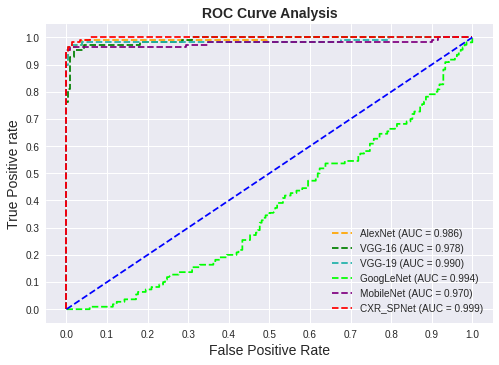

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='DFU_EfficientNetV1 (AUC = 0.986)')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='DFU_EfficientNetV2 (AUC = 0.978)')
plt.plot(fpr3, tpr3, linestyle='--',color='LightSeaGreen', label='DFU_EfficientNetV3 (AUC = 0.990)')
plt.plot(fpr4, tpr4, linestyle='--',color='lime', label='DFU_EfficientNetV4 (AUC = 0.994)')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=14)
plt.legend(prop={'size':14}, loc='lower right')
# x label
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('False Positive Rate', fontsize=14)
# y label
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive rate', fontsize=14)

plt.legend(loc='best')
plt.savefig('ROC curve',dpi=400)
plt.show();